In [165]:
from torch_geometric.datasets import KarateClub
from graph_torch.dynamicGraph import dynamicGraph
from graph_torch.sampler.n2v_random_walk import UnweightedNode2vecSampler
from graph_torch.nn.node2vecLayer import node2vec_layer
import torch
from torch.optim import SparseAdam
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [234]:
from torch import rand

dataset = KarateClub()[0]
embedding_dim = 128
node_num = dataset.num_nodes

# Initialize graph 
dg = dynamicGraph()

# Add randomly initialized node embeddings to the graph
dg.add_nodes({ "w": rand(node_num, embedding_dim) / 10, # TO DO: initialize node embeddings by calling the Node class
              "s": rand(node_num, embedding_dim) 
             })

# Add edges to the graph
dg.add_edges(edge_type = "e", 
             U = dataset.edge_index[0], 
             V = dataset.edge_index[1], 
             directed = False
            )


In [235]:
# Get node data
dg.get_node_data('w')

Parameter containing:
tensor([[0.0314, 0.0119, 0.0202,  ..., 0.0176, 0.0044, 0.0364],
        [0.0557, 0.0467, 0.0084,  ..., 0.0497, 0.0051, 0.0009],
        [0.0707, 0.0415, 0.0763,  ..., 0.0436, 0.0150, 0.0004],
        ...,
        [0.0659, 0.0580, 0.0007,  ..., 0.0919, 0.0215, 0.0116],
        [0.0131, 0.0310, 0.0288,  ..., 0.0007, 0.0550, 0.0535],
        [0.0535, 0.0936, 0.0070,  ..., 0.0661, 0.0458, 0.0765]],
       requires_grad=True)

In [236]:
# Get edge data
dg.get_edges('e')

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]),
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  

In [237]:
n2v_sampler = UnweightedNode2vecSampler(graph = dg, 
                                        edge_type = 'e', 
                                        walk_length = 15, 
                                        context_size = 5, 
                                        walks_per_node = 10,
                                        num_negative_samples = 1, 
                                        p = 0.5, 
                                        q = 1, 
                                        sparse = True
                                       )

generator = n2v_sampler.generator(batch_size = 10, 
                                  shuffle = True, 
                                  num_workers = 0,
                                  batch = None
                                 )

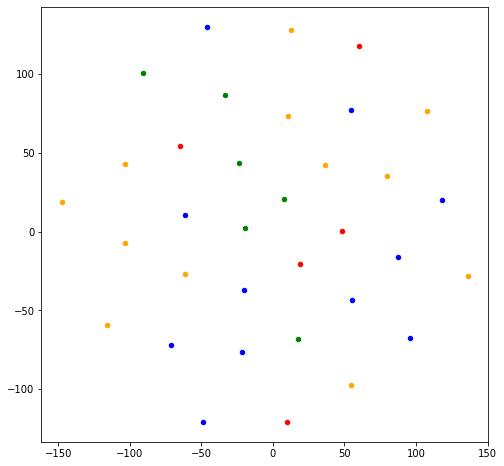

In [238]:
n2v_layer.eval()
z = dg.get_node_data('w').detach()#n2v_layer(torch.arange(dg.get_nodes_num())).detach()
z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
y = dataset.y.cpu().numpy()

colors = ['blue', 'red', 'orange', 'green']
plt.figure(figsize=(8, 8))
for i in range(dataset.y.max().item() + 1):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])

In [239]:
epochs = 1000
lr = 0.01
n2v_layer = node2vec_layer(graph = dg, 
                           node_type = 'w'
                          )
optimizer = SparseAdam(list(n2v_layer.parameters()), lr = lr)

n2v_layer.train()
for i in range(epochs):
    for pos, neg in generator:
        optimizer.zero_grad()
        loss = n2v_layer.loss(pos, neg)
        loss.backward()
        optimizer.step()

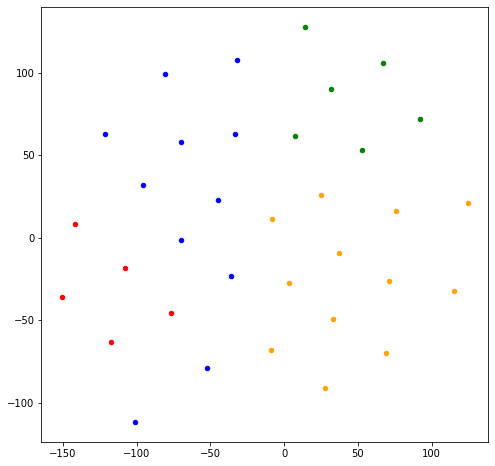

In [240]:
n2v_layer.eval()
z = n2v_layer(torch.arange(dg.get_nodes_num())).detach()
z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
y = dataset.y.cpu().numpy()

colors = ['blue', 'red', 'orange', 'green']
plt.figure(figsize=(8, 8))
for i in range(dataset.y.max().item() + 1):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
#plt.axis('off')